## 0. Introduction

This notebook tries to explore different ways to model the spatial dynamics of coronavirus infections in Germany.

**Disclaimer**: This is just a fun little side project. I am by no means an expert on epidemiology, medicine or anything of the like. Please don't take any findings in this notebook as authoritative! My hope is only to learn a little bit about spatial modelling, and maybe get lucky and inspire somebody in their own work.

The notebook itself imports and uses a few simple models, and adds a few notes to illustrate some, hopefully intersting, points and characteristics of these models. The models themselves are defined in the file `models.py`. Data preprocessing has been done in `data.py`.


Let's first import libraries and data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, animation
from IPython.display import HTML
import pandas as pd
import geopandas as gpd

In [2]:
from models import simpleModel, stepModel, spatialModelFracConn, spatialModelNO2, spatialModelNO2alpha, minimize, msse, getMsseRelative
from plotting import plotSim, plotSimCuml, plotSimMulti, scatterHistory, video, getIndex

We have a dataset of confirmed infections for points in time (daily) and space (districts, 'Landkreise' in German, here abbreviated as *LK*).

In [3]:
data = gpd.read_file('./data/landkreise_no2_14d.json')
dateColNames = data.columns[5:-10]

In [4]:
incubationTime = 7
t_curfew = np.where(dateColNames == '22.03.2020')[0][0]
t_curfew_effect = t_curfew + incubationTime

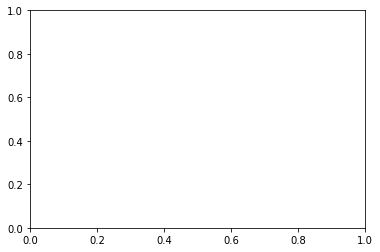

In [5]:
fig, ax = plt.subplots(1, 1)
rawData = data[dateColNames].values
minval = np.min(rawData)
maxval = np.max(rawData)

def init():
    data.plot(column=dateColNames[0], ax=ax, vmin=minval, vmax=maxval)

def animate(i):
    data.plot(column=dateColNames[i], ax=ax, vmin=minval, vmax=maxval)

#a = animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=len(dateColNames))
# HTML(a.to_jshtml())
#a.save('./output/obs.gif', writer='imagemagick', fps=30)

Plotting the data shows a clear spatial aspect to the spread of the virus:


![obs](./output/obs.gif)

## 1. Simple model

Commonly, infection numbers are assumed to have logistic growth:

$$ \frac{dn}{dt} = \alpha n \left(1 - \frac{n}{K} \right) $$

Where $n(t)$ is the number of infections at time $t$, $\alpha$ is the growth rate, and $K$ is the carrying capacity (the maximum number of people that can get infected).

Note that this model does not have a spatial component - it does not account for traffic from other regions into the study area.

In a first step, we'll use this model to capture infection numbers for all of Germany.

In [6]:
n_obs = data[dateColNames].values
nrPlaces, nrTimesteps = n_obs.shape
population = data['population'].values
Ks = population
n0 = n_obs[:, 0]

In [7]:
n_obs_cuml = np.sum(n_obs, axis=0).reshape((1, nrTimesteps))
population_cuml = np.sum(population)
K_cuml = population_cuml
n0_cuml = n_obs_cuml[:, 0]

In [8]:
results_simple_cuml, _ = minimize(n_obs_cuml, simpleModel, [0.18], [(0.0001, 1.0000)], [1, nrTimesteps, K_cuml, n0_cuml], msse)
results_simple_cuml

      fun: 14227210870.19923
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-17929.07714844])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 26
      nit: 4
   status: 0
  success: True
        x: array([0.18259509])

In [9]:
n_sim_simple_cuml = simpleModel(results_simple_cuml.x[0], 1, nrTimesteps, K_cuml, n0_cuml)

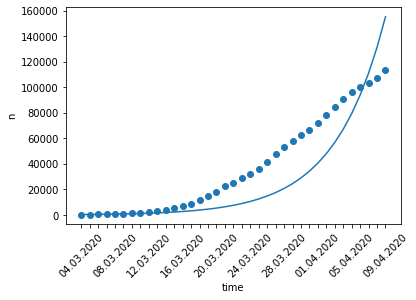

In [10]:
plotSim(dateColNames, n_obs_cuml, n_sim_simple_cuml[0])

This model does ok for cumulative data.
But we'll see that results are terrible if we try to use the same model for deaggregated LKs.
The reason is mostly `n0`: most LKs don't initially have any infections, so this model always predicts 0 for these LKs.

When used for deaggregated data, this model will effectively only calibrate on to those LKS with n0 != 0. Really, attempting to use this model for LKs is a gross abuse of its original intent. We'll do it anyway here, because it illustrates nicely the need for a spatial component in the model if we want to mirror local dynamics.

In [11]:
msseRelPop = getMsseRelative(population / 10000)
results_simple, _ = minimize(n_obs, simpleModel, [0.18], [(0.0001, 1.0000)], [nrPlaces, nrTimesteps, Ks, n0], msseRelPop)
results_simple

      fun: 868937.278821977
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.01164153])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 34
      nit: 7
   status: 0
  success: True
        x: array([0.09755405])

In [12]:
n_sim_simple = simpleModel(results_simple.x[0], nrPlaces, nrTimesteps, Ks, n0)
msseRelPop(n_obs, n_sim_simple)

868937.278821977

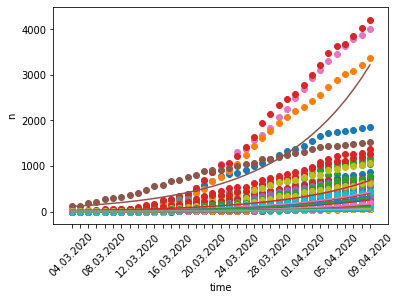

In [13]:
n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, nrPlaces):
    # This model can only  provide predictions for those LKs that actually have infections at time 0.
    if n_obs[i, 0] != 0:
        n_obs_plt.append(n_obs[i])
        n_sim_plt.append(n_sim_simple[i])
        names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

When we use the simple model to predict local values, we get ok predictions for all those places that have `n0 != 0`.
When we use instead the value of $\alpha$ that fits cumulated values, we get a massive overestimation of those local values.



In [14]:
n_sim_simple_x = simpleModel(results_simple_cuml.x[0], nrPlaces, nrTimesteps, Ks, n0)
msseRelPop(n_obs, n_sim_simple_x)

10383448.3560571

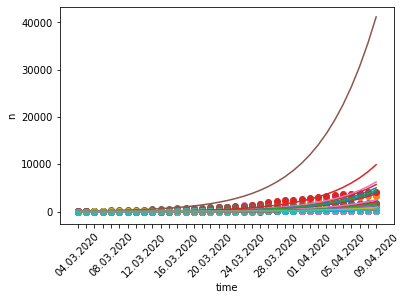

In [15]:
n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, nrPlaces):
    # This model can only  provide predictions for those LKs that actually have infections at time 0.
    if n_obs[i, 0] != 0:
        n_obs_plt.append(n_obs[i])
        n_sim_plt.append(n_sim_simple_x[i])
        names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

We can learn a few things from this:

  1. If we want to predict local values, we need to use a model that takes location and traffic explicitly into account.

  2. If we don't do that, we get a value for $\alpha$ that differs massively from the global one, because that non-global alpha is effectively only being calculated from the places that have `n0 != 0`

  3. Also note that this model, when used for cumulated vs. deaggregated data, has very different interpretations:
the model with cumulated data assumes perfect mixing between LKs, the model with deaggregated data assumes no mixing at all.

Before we start work on modelling spatial growth, however, we'll add a little tweak to the model, to account for quarantaine measures.

## 2. Simple model with step in $\alpha$

On 22nd of March 2020, measures have been introduced to reduce the spread of the corona virus. These measure primarily consist of reduced traffic, social distancing and individual hygiene. In our model, this process can be captured by allowing for another value of $\alpha$ from 22nd of March onwards. (In fact, those measures only fully take effect after that point, because many people will have been infected at some point before the 22nd, but only show symptoms after a certain incubation time.)

$$ 
\alpha(t) = 
\begin{cases}
    \alpha_0 \text{ if } t < t_0 \\
    \alpha_1 \text{ else}
\end{cases} 
$$

This model does better in fitting to cumulative data, but suffers from the same shortcomings as the simple model when it comes to deaggregated data.

In [16]:
results_step_cuml, _ = minimize(n_obs_cuml, stepModel, [0.22, 0.25], [(0.0001, 1.0000), (0.0001, 1.0000)], [1, nrTimesteps, K_cuml, n0_cuml, t_curfew_effect], msse)
results_step_cuml

      fun: 803695251.0067716
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1672303.67660522,  105214.11895752])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 15
   status: 0
  success: True
        x: array([0.22963906, 0.22929206])

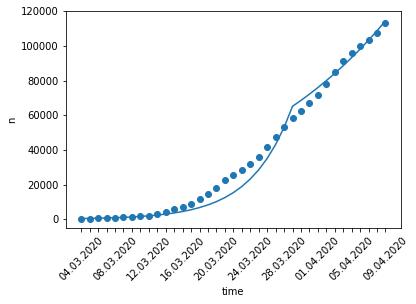

In [17]:
n_sim_step_cuml = stepModel(*(results_step_cuml.x), 1, nrTimesteps, K_cuml, n0_cuml, t_curfew_effect)
plotSimCuml(dateColNames, n_obs_cuml, n_sim_step_cuml)

As expected, this model has a much lower MSE than the simple model from section 1. And, again as expected, this model cannot be used to capture local dynamics when some LKs initially don't have any cases.

In [18]:
results_step, _ = minimize(n_obs, stepModel, [0.18, 0.25], [(0.0001, 1.0000), (0.0001, 1.0000)], [nrPlaces, nrTimesteps, Ks, n0, t_curfew_effect], msseRelPop)
results_step

      fun: 862096.8440938375
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.51808625, -0.11641532])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 14
   status: 0
  success: True
        x: array([0.11807989, 0.22821469])

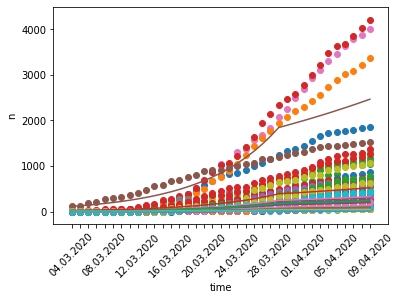

In [19]:
n_sim_step = stepModel(*(results_step.x), nrPlaces, nrTimesteps, Ks, n0, t_curfew_effect)
n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, nrPlaces):
    # This model can only  provide predictions for those LKs that actually have infections at time 0.
    if n_obs[i, 0] != 0:
        n_obs_plt.append(n_obs[i])
        n_sim_plt.append(n_sim_step[i])
        names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

Again, this model yields ok results where `n0 != 0`, but is unusable for any other location. 

## 3. Spatial model

We now define a first, simple, spatial model that explicitly accounts for traffic between regions.

Let's assume we can calculate a measure of _connectivity_ $C_{x, y, t}$ between location $x$ and $y$ at time $t$. ($C_{x, y, t}$ depends on $t$ because with the curfew people will travel less). Then we can explicitly integrate this connectivity in our growth formula:

$$ \frac{dn(x, t)}{dt} = \alpha(t) \left( \sum_y C_{y, x, t} n(y, t) \right) \left(1 - \frac{n(x, t)}{K} \right) $$

Note here that $C_{x, x, t}$ stands for the connectivity within one LK, i.e. traffic within a city/region, probably consisting of commuting, shopping etc. 

As an interesting side effect, with transportation explicitly accounted for, all changes to $\alpha$ must stem from the remaining measures, hygiene and social distancing.

In this first, simple model, we create a dummy-connectivity from parameters $u_1$ and $u_2$.

First, to calculate the connectivity before the curfew, we follow these simple steps:
$$
C_{x, y} = 
\begin{cases}
    1 \text{ if x = y } \\
    u_1 \text{ if x and y are neighbors } \\
    u_2 \text{ if x and y share one neighbor } \\
    0 \text{ otherwise}
\end{cases}
$$

After the curfew, we simply reduce the connectivity by a scalar $m$:
$$ C_{x, y, 1} = m \cdot C_{x, y, 0} $$

Both $u$ and $m$ will be calibrated.

**Note**: this is definitely not a good way of modelling actual connectivity. It would be very useful if we could find a good way to estimate how many people travel from a to b (maybe analyzing social media data?). Also, other decaying rates should be explored, like inverse squared distance, krigging etc. 

In [20]:
geometries = data.geometry
results_spatial, _ = minimize(n_obs, spatialModelFracConn, [0.065, 0.4, 0.22, 0.15, 0.5], [(0.01, 0.3), (0.1, 1), (0.1, 0.5), (0.01, 0.5), (0.01, 1)], [nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew], msseRelPop)
results_spatial

... 1 calls made ...
... 2 calls made ...
... 3 calls made ...


      fun: 521934.8774605693
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -297.74964787,   -381.56867959, 100034.46950577,   -169.10489649,
          232.71422833])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 354
      nit: 38
   status: 0
  success: True
        x: array([0.09359407, 0.45842   , 0.1       , 0.0637644 , 0.59194799])

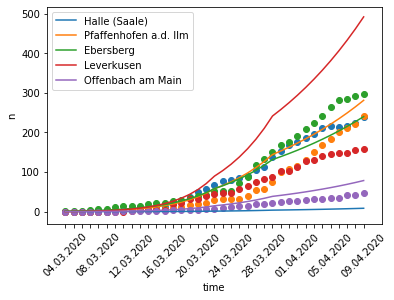

In [21]:
n_sim_spatial = spatialModelFracConn(*(results_spatial.x),
                        nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew)

n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, 50, 10):
    n_obs_plt.append(n_obs[i])
    n_sim_plt.append(n_sim_spatial[i])
    names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

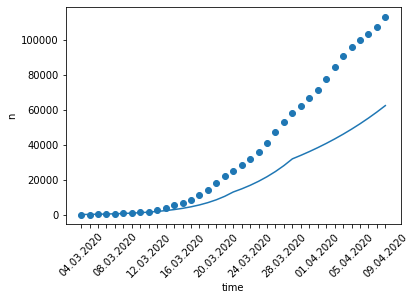

In [22]:
plotSimCuml(dateColNames, n_obs, n_sim_spatial)

With this model we can finally obtain any meaningful values for LKs that did not initially have infections. But the fit isn't quite ideal. Let's see if we can do better with extra information about traffic.

## 4. Spatial model with connectivity reduction estimated from NO2

On Copernicus Hub, ESA makes data from the Sentinel 5P mission available, which, among many other things, measures $NO_2$ pollution in the atmosphere. If this data correlates with traffic, it can be used to account for the effects of the curfew - the less travel, the more people adhere to the curfew. This data is especially useful for us because traffic may have dropped at different rates in different places. The high resolution of the Sentinel 5P data allows us to observe regional differences in traffic reduction.

Our data has been obtained from the [Copernicus Atmosphere Monitoring Service](https://apps.ecmwf.int/datasets/data/cams-nrealtime/levtype=sfc/
).

Note, however, that not  all $NO_2$ is produced by cars. Other sources include refineriesor coal plants. The percentage of $NO_2$ produced by vehicles varies widely between locations, but seems to be somewhere between 40-80%. The fraction of $NO_2$ that actually stems from trafic is one of the parameters to be calibrated for this model. But in reality that fraction will likely vary very much from place to place, so using one global variable can only ever be an approximation of the real situation.

Once we know the fraction $f_{NO_2}$ by which $NO_2$ has dropped due to reduction in traffic, we can use this to update our connectivity (instead of using the global variable $u$ like in section 3):

$$ C_{x, y, 1} = f_{NO_2} \cdot C_{x, y, 0} $$


In [35]:
no2_before = data['obs_no2_mean_before'].values
no2_after = data['obs_no2_mean_after'].values
results_no2, _ = minimize(n_obs, spatialModelNO2, [0.1, 0.35, 0.22, 0.1, 0.5], [(0.01, 1), (0.1, 1), (0.1, 1), (0.01, 0.5), (0.1, 0.9)], [nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, no2_before, no2_after], msseRelPop)
results_no2

      fun: 479952.8795895515
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.70315616e+01,  2.32830644e-02,  1.32589473e+05, -9.44128260e+00,
       -2.61609908e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 294
      nit: 28
   status: 0
  success: True
        x: array([0.09562278, 0.34748674, 0.1       , 0.02716121, 0.9       ])

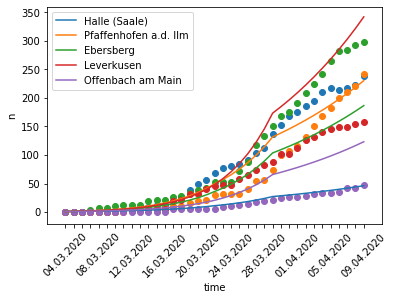

In [36]:
n_sim_no2 = spatialModelNO2(*(results_no2.x),
                        nrPlaces, nrTimesteps, Ks, n0, geometries, t_curfew_effect, t_curfew, no2_before, no2_after)

n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, 50, 10):
    n_obs_plt.append(n_obs[i])
    n_sim_plt.append(n_sim_no2[i])
    names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

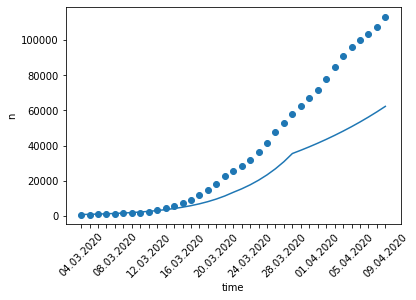

In [37]:
plotSimCuml(dateColNames, n_obs, n_sim_no2)

Including NO2 data delivers somewhat better results than the previous model, but the cumulative curve shows that we're still clearly making some systematic error.

## 5. Spatial model with NO2 and localized $\alpha$

With the Sentinel data we have certainly gained some insight into the spatial distribution of traffic. But still our model did not fit reality  very well. It seems that $\alpha$, which up to now we have assumed to be the same for every location, might in reality differ from place to place - meaning that some LKs have more success in reducing infection rates than others. 

Naively, we'd just add one $\alpha_x$ for every location $x$ to the list of our model parameters. However, this would result in us calibrating several hundreds of parameters - not usually an easy thing to do. We could however reduce the workload on our calibration algorithm if we found a good estimator for $\alpha_x$.

While there is (as far as I am aware) no analytical least-squares estimator for $\alpha_x$, simple arithmetic does get us very far:

$$ \alpha_x = \frac{dn(x, t)}{dt} \frac{1}{ \sum_y C_{y, x, t} n(y, t) } \frac{K - n(x, t)}{K} $$

Astonishingly, just taking the average of this expression over all pairs of observations $(n_{t-1}, n_t)$ yields a decent estimation.

$$ \hat{\alpha}_x = \sum_t (n(x, t) - n(x, t-1)) \frac{1}{ \sum_y C_{y, x, t} n(y, t) } \frac{K - n(x, t)}{K} $$

In [26]:
results_alpha, _ = minimize(n_obs, spatialModelNO2alpha, [0.2, 0.1, 0.7], [(0.01, 1), (0.01, 1), (0.1, 0.95)], [Ks, geometries, t_curfew_effect, t_curfew, n_obs, no2_before, no2_after], msseRelPop)
results_alpha

      fun: 93605.60902535074
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.1717126 , -0.7377821 ,  0.08149073])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 76
      nit: 16
   status: 0
  success: True
        x: array([0.07785674, 0.4297616 , 0.76424961])

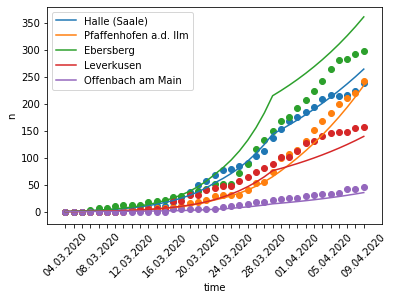

In [27]:
n_sim_alpha, connectivity0, connectivity1, alphas0, alphas1 = spatialModelNO2alpha(*(results_alpha.x),
                    Ks, geometries, t_curfew_effect, t_curfew, n_obs, no2_before, no2_after, True)


n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, 50, 10):
    n_obs_plt.append(n_obs[i])
    n_sim_plt.append(n_sim_alpha[i])
    names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

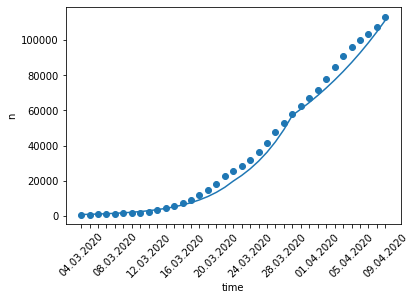

In [28]:
plotSimCuml(dateColNames, n_obs, n_sim_alpha)

With local estimates for alpha, the model finally also gives a decent approximation of global infections - indicating that we've reduced systemic errors. 

## 6. Comparing predictions between all the models for a few LKs

We have created a series of models of increasing complexity. Let's compare how their predictions look for different LKs.

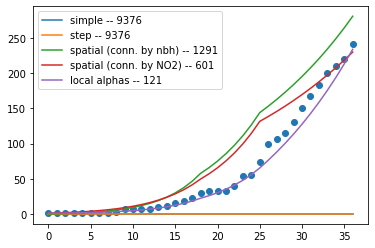

In [38]:
simulations = [n_sim_simple, n_sim_step, n_sim_spatial, n_sim_no2, n_sim_alpha]
modelnames = ['simple', 'step', 'spatial (conn. by nbh)', 'spatial (conn. by NO2)', 'local alphas']

i = 10
t = np.arange(len(dateColNames))
plt.scatter(t, n_obs[i])
for name, sim in zip(modelnames, simulations):
    err = int(np.mean((n_obs[i] - sim[i])**2))
    label = f"{name} -- {err}"
    plt.plot(t, sim[i], label=label)
plt.legend()

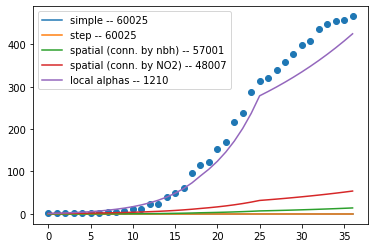

In [39]:
i = 100
plt.scatter(t, n_obs[i])
for name, sim in zip(modelnames, simulations):
    err = int(np.mean((n_obs[i] - sim[i])**2))
    label = f"{name} -- {err}"
    plt.plot(t, sim[i], label=label)
plt.legend()

## 7. Exploring spatial and temporal growth

With an acceptable spatial model on our hands now, let's create some maps.

Text(0.5, 1, 'alpha1 / alpha0')

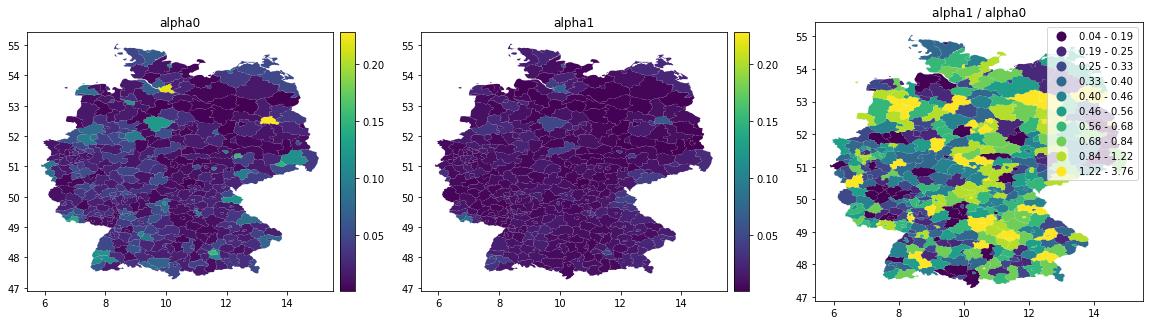

In [31]:
data['alpha0'] = alphas0
data['alpha1'] = alphas1
data['frac_alpha'] = data['alpha1'] / data['alpha0']
minval = np.min(data['alpha0'])
maxval = np.max(data['alpha0'])

fig, axes = plt.subplots(1, 3, figsize=(20,9))
divider0 = make_axes_locatable(axes[0])
divider1 = make_axes_locatable(axes[1])
# divider2 = make_axes_locatable(axes[2])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
# cax2 = divider2.append_axes("right", size="5%", pad=0.1)
data.plot(column='alpha0', axes=axes[0], legend=True, cax=cax0, vmin=minval, vmax=maxval)
data.plot(column='alpha1', axes=axes[1], legend=True, cax=cax1, vmin=minval, vmax=maxval)
data.plot(column='frac_alpha', axes=axes[2], legend=True, scheme='quantiles', k=10)  #cax=cax2, 
axes[0].set_title('alpha0')
axes[1].set_title('alpha1')
axes[2].set_title('alpha1 / alpha0')

Overall, the growth rate has clearly been reduced. Note that the third map shows a few LKs that actually have a *higher* growth rate after the curfew - but these are probably errors caused by either low case numbers or model insufficiencies (for example, traffic is likely not equally important everywhere).

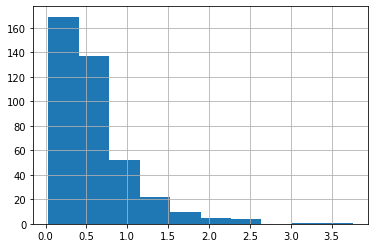

In [32]:
data['frac_alpha'].hist()

Indeed, the largest part of LKs have a `frac_alpha` below 1.

In [33]:
for i, date in enumerate(dateColNames):
    data[date + "_sim"] = n_sim_alpha[:, i]
    data[date + "_delta"] = data[date] - data[date + "_sim"]

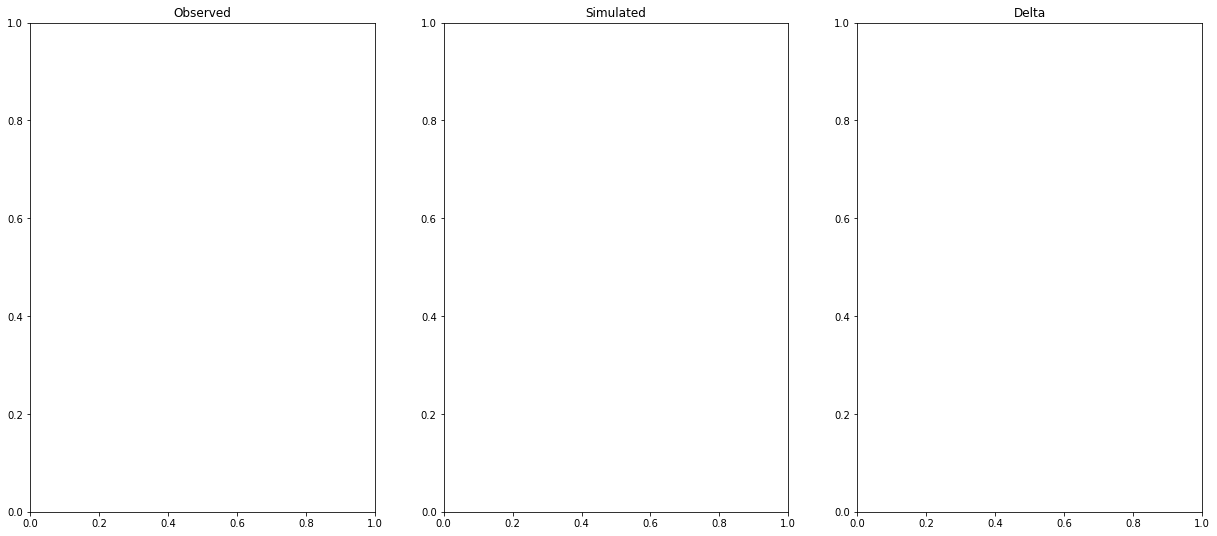

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(21, 9))
rawData = data[dateColNames].values
minval = np.min(rawData)
maxval = np.max(rawData)
axes[0].set_title("Observed")
axes[1].set_title("Simulated")
axes[2].set_title("Delta")

def init():
    data.plot(column=dateColNames[0], ax=axes[0], vmin=minval, vmax=maxval)
    data.plot(column=(dateColNames[0] + "_sim"), ax=axes[1], vmin=minval, vmax=maxval)
    data.plot(column=(dateColNames[0] + "_delta"), ax=axes[2])

def animate(i):
    data.plot(column=dateColNames[i], ax=axes[0], vmin=minval, vmax=maxval)
    data.plot(column=(dateColNames[i] + "_sim"), ax=axes[1], vmin=minval, vmax=maxval)
    data.plot(column=(dateColNames[i] + "_delta"), ax=axes[2])

#a = animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=len(dateColNames))
# HTML(a.to_jshtml())
#a.save('./output/obs_vs_sim.gif', writer='imagemagick', fps=30)

![obsvsim](./output/obs_vs_sim.gif)